In [1]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.extensions.unitary import UnitaryGate
from qiskit.circuit.library.standard_gates import CZGate
from qiskit.circuit.library.standard_gates import CHGate
from qiskit.circuit.library.standard_gates import SGate

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [2]:
provider = IBMQ.load_account()

In [3]:
def rand_numb(low_in,high_in):
    '''
    Returns a random number between low_in and high_in, including both end points.
    '''
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

In [4]:
'''
Define variables for the number of layers and qubits of the prover. Define global variables used in the optimization.
'''
numLayer = 5
numQubit = 3
global iterations
global noisy

In [5]:
def createProver(numQubit, numLayer):
    '''
    Creates a parameterized unitary on numQubit qubits. Applies numLayer layers of the HEA with 2 Qiskit.parameters 
    per qubit per layer, specifying rotations about the x- and y-axes. After each layer, applies a neighbouring qubit
    CNOT layer. Returns a QuantumCircuit object containing the parameterized prover. 
    '''
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

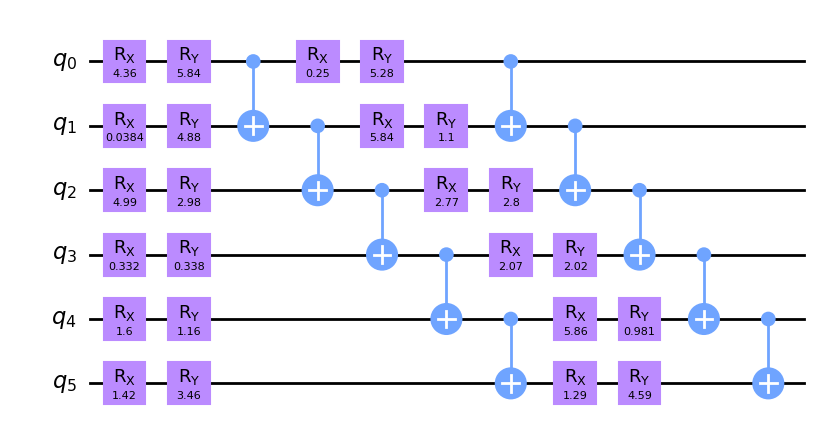

In [6]:
'''
Defines parameters that specify the purification of state to be tested. Create a QuantumCircuit object that
creates the purification on (size) number of qubits.
'''
unitary_param_1 = np.array([])
size = 6
layers = 2

for i in range(0, 2*size*layers):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [7]:
def createEqSuperposQuaternion():
    '''
    Defines a quantum circuit to create the uniform superposition of basis elements required.
    '''
    temp = QuantumCircuit(2)
    temp.h(0)
    temp.h(1)
    return temp

In [9]:
def createQuantumCircuit(state, numQubit, numLayer):
    '''
    Creates quantum circuit for the problem. 
    Refer to Appendix 6 from https://arxiv.org/pdf/2105.12758
    The ciruit contains 8 qubits each labelled as (C, S, S')
    '''
    circ = QuantumCircuit(8)
    
    superPosCircuit = createEqSuperposQuaternion()
    circ.append(superPosCircuit, [0, 1])
    circ.append(state, [2, 3, 4, 5, 6, 7])

    prover = createProver(numQubit, numLayer)
    circ.append(prover, [5, 6, 7])
    
    circ.barrier()
    controlledU1 = SGate().control(1)
    controlledU1b = SGate().inverse().control(1)
    
    circ.append(controlledU1, [1, 2])
    circ.append(controlledU1, [1, 3])
    circ.append(controlledU1, [1, 4])
    
    circ.append(controlledU1b, [1, 5])
    circ.append(controlledU1b, [1, 6])
    circ.append(controlledU1b, [1, 7])
    
    circ.append(CZGate(), [0, 2])
    circ.append(CZGate(), [0, 3])
    circ.append(CZGate(), [0, 4])

    circ.append(CZGate(), [0, 5])
    circ.append(CZGate(), [0, 6])
    circ.append(CZGate(), [0, 7])
    
    circ.append(superPosCircuit.inverse(), [0, 1])

    return circ

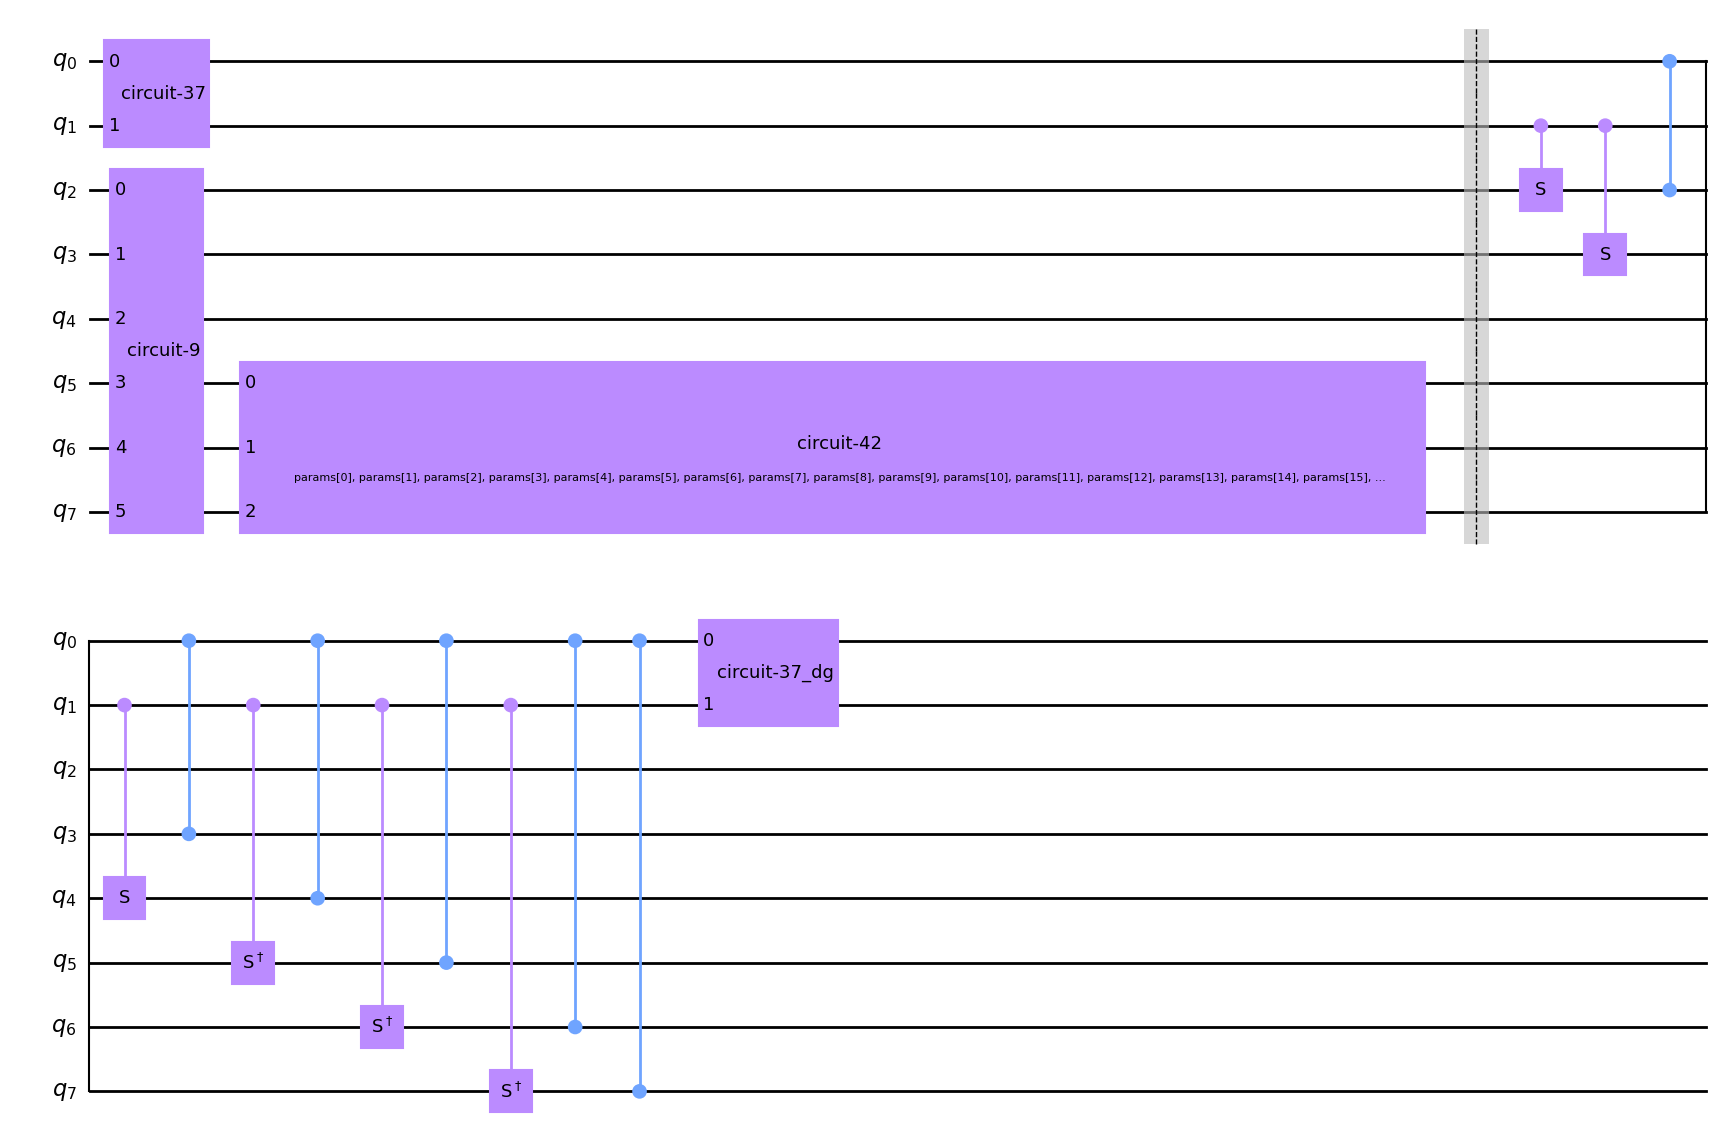

In [12]:
'''
Creates the quantum circuit
'''
qCirc = createQuantumCircuit(state, numQubit, numLayer)
qCirc.draw('mpl')

In [13]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19]), ParameterVectorElement(params[20]), ParameterVectorElement(params[21]), ParameterVectorElement(params[22]), ParameterVectorElement(params[23]), ParameterVectorElement(params[24]), ParameterVectorElement(params[25]), ParameterVectorElement(params[26]), ParameterVectorElement(

In [14]:
'''
Pick a backend to use. We use the statevector_simulator for noiseless simulation.
'''
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [15]:
'''
Pick a backend to use. We use the qasm_simulator for noisy simulation. 
'''
#Replace the provider with your personal credentials for hub, group and main
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [16]:
def costf(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the expectation value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [17]:
def gradient(params):
    '''
    Assigns the params input to the parameters of the ansatz, and calculates the gradient value.
    '''
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [18]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    '''
    Callback function called automatically during optimization. Appends loss value, current iteration and 
    prints every iteration with a completion percentage.
    '''
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [19]:
'''
Average value of this hamiltonian is the probability of measuring 0 on the first two qubits.
MatrixOp(np.array([[1, 0], [0, 0])) is the projector on the 0 subspace. Qiskit orders qubits in reverse.
'''
hamiltonian = I^I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [20]:
'''
Initialize prover parameters to random angles
'''
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[0.86613399 5.27204361 3.81998218 5.68672429 2.4662107  3.83121335
 6.22962039 0.43864342 2.89412873 3.04265441 1.69704066 3.50587404
 3.27965634 2.92474664 0.68654507 0.19945769 0.92312684 3.8457201
 0.28190834 1.20412374 4.26781388 1.98131051 0.83019579 4.32311127
 3.92940631 5.94704808 4.60684924 3.07022669 3.98296507 4.88604385]
Initial Cost :  0.340226366927849


In [21]:
'''
True value calculated using the SDP.
'''
true_value = 0.5

In [22]:
'''
Perform the noiseless optimization using the SPSA algorithm for 200 iterations.
'''
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.340226366927849


KeyboardInterrupt: 

In [ ]:
'''
Perform the noisy optimization using the SPSA algorithm for 200 iterations.
'''
noisy = True
noisy_loss = []
noisyParam = np.copy(paramProver)
-1*costf(noisyParam)
print("Initial Cost : ", -1*costf(noisyParam))
autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

Initial Cost :  0.44873046875


In [23]:
'''
Evaluate the noiseless cost function using the parameters learned from the noisy optimization. 
'''
noisy = False
noiseResilientValue = -1*costf(x_opt)
print(noiseResilientValue)

NameError: name 'x_opt' is not defined

In [96]:
'''
Print all final values after training.
'''
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
#print("Noisy : ", noisy_loss[-1])
#print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.5
Noiseless :  0.4989699626752722


In [24]:
def writeToFile():
    '''
    Write the training data to a text file to be used to plot the data. The format is as follows:
        True Value
        Noise Resilient Value
        Size of noiseless data list
        [
        Noiseless data with one entry per line
        ]
        Size of noisy data list
        [
        Noisy data with one entry per line
        ]
    '''
    file = open("CZ_GS.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(true_value)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss[0:len(noiseless_loss)-1]]
    file.writelines(L)
    
    file.write(str(noiseless_loss[-1]))
    
    file.close()

In [29]:
writeToFile()